In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns; sns.set()  # for plot styling
import numpy as np
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.metrics import pairwise_distances_argmin
from sklearn.datasets import make_moons
import pandas as pd
import os

os.chdir(r"D:\git-repos\mluerig\jena_clustering_lecture")
from utils import refactor_array

# Clustering

In this notebook we will use clustering, a type of unsupervised machine learning, to sort leaves into distinct groups based on their traits.


## the k-means algorithm

K-means clustering  is a method that partitions data into 'k' distinct clusters. The 'means' in k-means refers to the centroids or the geometric centers of these clusters. The algorithm iteratively assigns each data point to the nearest cluster, while optimizing the positions of the cluster centroids. 

This algorithm's beauty lies in its simplicity and effectiveness, making it a widely used tool in various fields, including biology. In biological contexts, k-means can be instrumental in grouping similar gene expressions, categorizing types of cells in imaging data, or even in ecological niche partitioning.

## Working principles

The *k*-means algorithm operates on the principle of partitioning a dataset into a specified number of clusters, each defined by its unique characteristics. This algorithm executes its task based on two key concepts:

 - The center of a cluster, referred to as the 'cluster centroid', is computed as the average of all data points assigned to that cluster.
 - Every data point is associated with the nearest cluster centroid, ensuring minimal distance from each point to its corresponding center.

These principles form the core of the *k*-means model. We will explore the specific mechanics of how the algorithm achieves this clustering.

## Herbarium trait dataset

In line with the unsupervised nature of this algorithm, our initial exploration will be conducted without utilizing any labels for the data points. This approach underscores the algorithm's ability to identify and group data based purely on the inherent structures within the dataset itself.

We first load the dataset as a dataframe, and then convert it to a numpy array so it's a bit easier to work with. I have pre-selected two traits: circularity (shape) and skewness (texture)

Text(0, 0.5, 'Skewness')

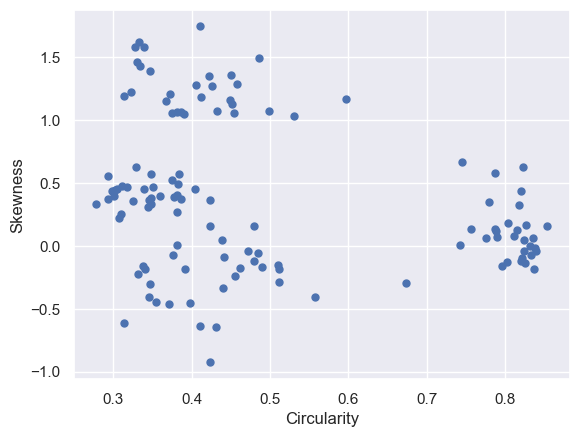

In [2]:
data_euc = pd.read_csv(r"data\eucalyptus_traits.csv")
plt.scatter(data_euc["circularity"], data_euc["gray_firstorder_Skewness"], s=25)
plt.xlabel('Circularity')
plt.ylabel('Skewness')

As you can see, we have four well define clusters.
Let's see how the *k*-means algorithm groups those data points.

In [3]:
X = data_euc[["circularity", "gray_firstorder_Skewness"]].to_numpy()
kmeans = KMeans(n_clusters=4, n_init=100)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)

Let's plot the cluster assignments as well as the centroids of each cluster.

Text(0, 0.5, 'Skewness')

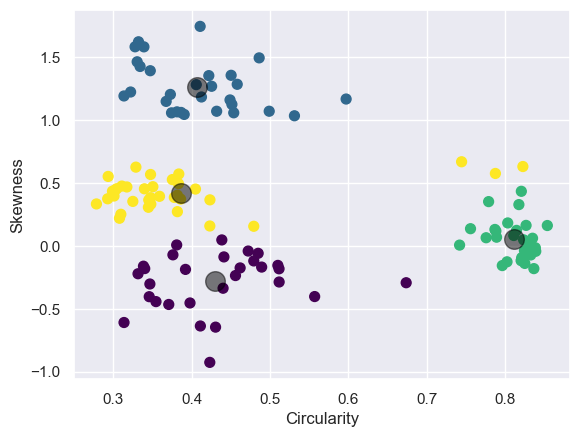

In [4]:
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);
plt.xlabel('Circularity')
plt.ylabel('Skewness')

The encouraging aspect of the *k*-means algorithm is its ability to categorize points into clusters in a manner quite similar to human intuition. This naturally raises a question: how does the algorithm efficiently identify these clusters, especially considering the astronomically high number of possible groupings in datasets with numerous data points? An exhaustive search through all possible combinations would be impractical due to its immense computational demand.

C:\Users\mluerig\AppData\Local\Temp\ipykernel_3876\2401977626.py:5: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax1.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5, cmap='viridis');


Text(0, 0.5, 'Skewness')

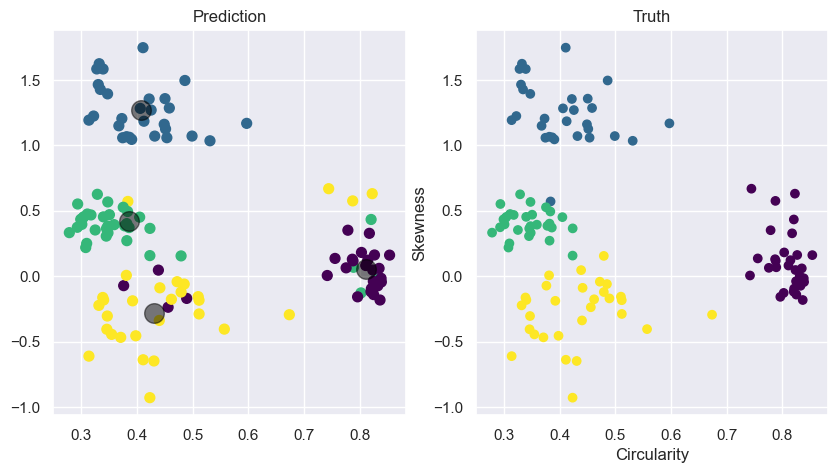

In [5]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))  # figsize controls the total size of the figure

# First plot
ax1.scatter(X[:, 0], X[:, 1], c=refactor_array(y_kmeans), s=50, cmap='viridis')
ax1.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5, cmap='viridis');
ax1.set_title('Prediction')
ax2.set_xlabel('Circularity')
ax2.set_ylabel('Skewness')

# Second plot
plt.scatter(data_euc['circularity'], data_euc["gray_firstorder_Skewness"], 
            c=pd.factorize(data_euc["species"])[0], cmap='viridis')
ax2.set_title('Truth')
ax2.set_xlabel('Circularity')
ax2.set_ylabel('Skewness')

## k-Means Algorithm: Expectation–Maximization

The *k*-means algorithm doesn't actually conduct an exhaustive search, but instead employs a more pragmatic and iterative method known as *expectation–maximization*. This approach smartly navigates through the data, making the task of finding clusters far more computationally manageable and efficient than one might initially assume, which makes Expectation-maximization (E-M) a crucial algorithm in data science

It involves the following steps:

1. __Initial Setup - Choosing Cluster Centers__:

 - The process begins by selecting initial positions for the cluster centers. This can be done randomly or based on specific criteria.

2. __Iterative Process__:

 - The algorithm then iterates through two main steps:

   __A. E-Step (Expectation)__:

    - In this step, each data point is assigned to the nearest cluster center. This assignment is based on the distance between the data point and the cluster centers.
   
   __B. M-Step (Maximization)__:

    - Here, the algorithm recalculates the position of each cluster center. The new position is determined by computing the mean of all data points assigned to that cluster.
3. __Convergence__:

 - These two steps (E-step and M-step) are repeated until the positions of the cluster centers stabilize and no longer change significantly. This indicates that the clusters have been effectively identified.
4. __Result and Analysis__:

 - Once the algorithm has converged, the final cluster centers define the grouping of the data. These clusters can then be analyzed to understand the underlying patterns and structures in the data.
The E-M algorithm in k-means is efficient and effective for many practical applications, particularly in organizing and understanding large datasets.

In summary: with each cycle of the E-step and M-step, the estimation of the cluster attributes improves. This is a key strength of the algorithm.

But let's see the expectation-maximation algorithm in action. Let's create a simple implementation of the *k*-means algorithm and then plot cluster assignments at each iteration.


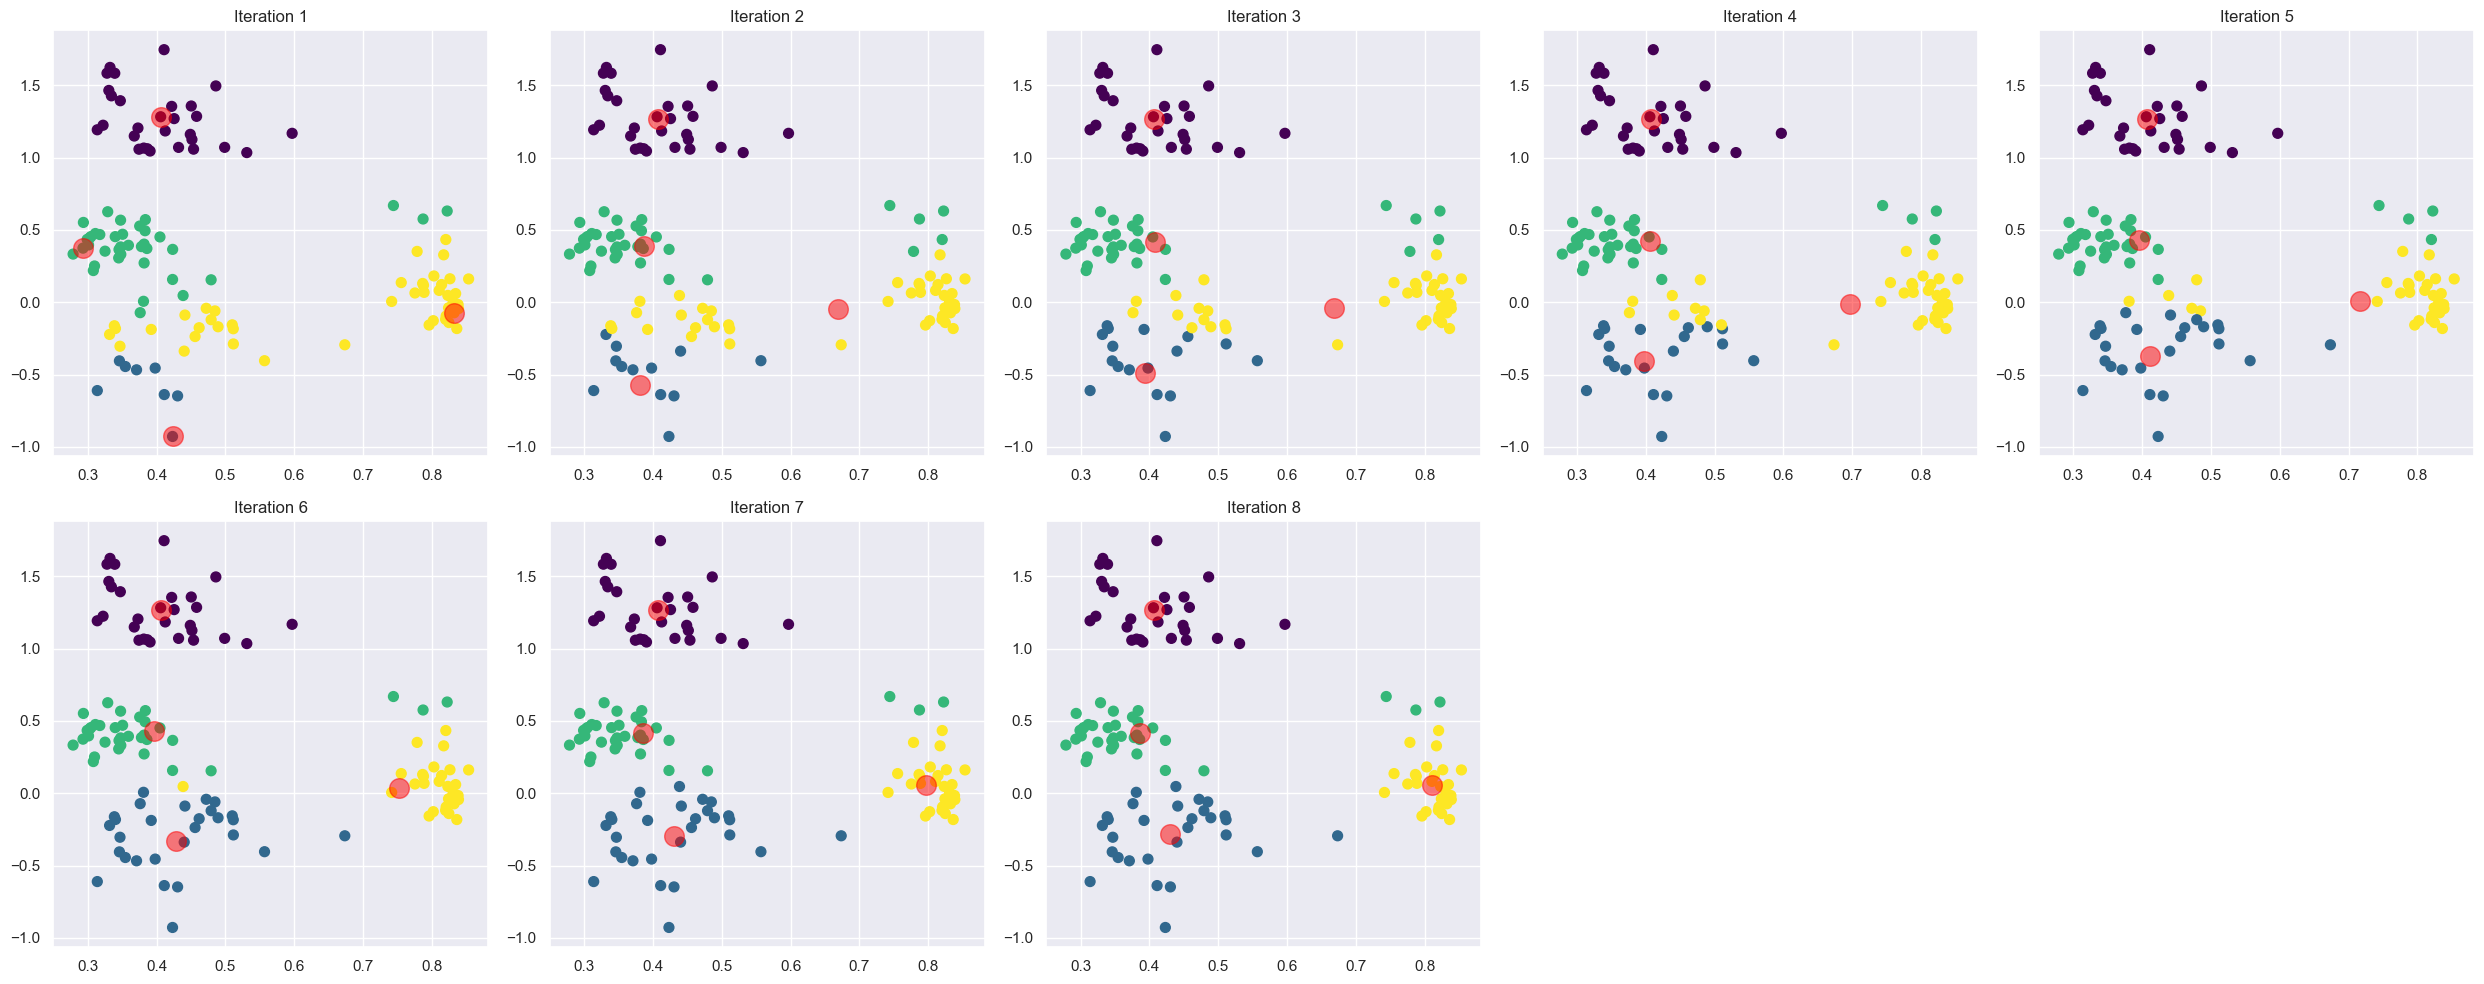

In [6]:
def store_cluster_data(X, centers, labels, n_clusters, plots_data):
    plots_data.append((X.copy(), centers.copy(), labels.copy()))

def find_clusters(X, n_clusters, rseed=2):
    rng = np.random.RandomState(rseed)
    i = rng.permutation(X.shape[0])[:n_clusters]
    centers = X[i]

    plots_data = []
    while True:
        labels = pairwise_distances_argmin(X, centers)
        new_centers = np.array([X[labels == i].mean(0) for i in range(n_clusters)])

        store_cluster_data(X, centers, labels, n_clusters, plots_data)

        if np.all(centers == new_centers):
            break
        centers = new_centers

    # Determine the number of rows and columns for the subplots
    num_iterations = len(plots_data)
    max_cols = 5
    num_rows = num_iterations // max_cols + (num_iterations % max_cols > 0)
    
    # Create subplots
    fig, axs = plt.subplots(num_rows, max_cols, figsize=(5 * max_cols, 5 * num_rows))
    axs = axs.flatten()  # Flatten in case of a single row

    # Plot each iteration
    for idx, (X_iter, centers_iter, labels_iter) in enumerate(plots_data):
        axs[idx].scatter(X_iter[:, 0], X_iter[:, 1], c=labels_iter, s=50, cmap='viridis')
        axs[idx].scatter(centers_iter[:, 0], centers_iter[:, 1], c='red', s=200, alpha=0.5)
        axs[idx].set_title(f"Iteration {idx+1}")

    # Hide any unused subplots
    for ax in axs[num_iterations:]:
        ax.axis('off')

    plt.tight_layout()
    plt.show()
    return centers, labels

# Example usage with your data 'X'
centers, labels = find_clusters(X, 4)


### Caveats - Local vs Global Minima

Like many iterative algorithms, there are a few issues to be aware of when using the *k*-means algorithm. One of these is the problem of converging to a local minimum.
Although the E-M procedure will navigate the loss landscape and improve the result in each step, there is no assurance that it will lead to the *global* minima. Certain seeds can lead to suboptimal clustering results. 

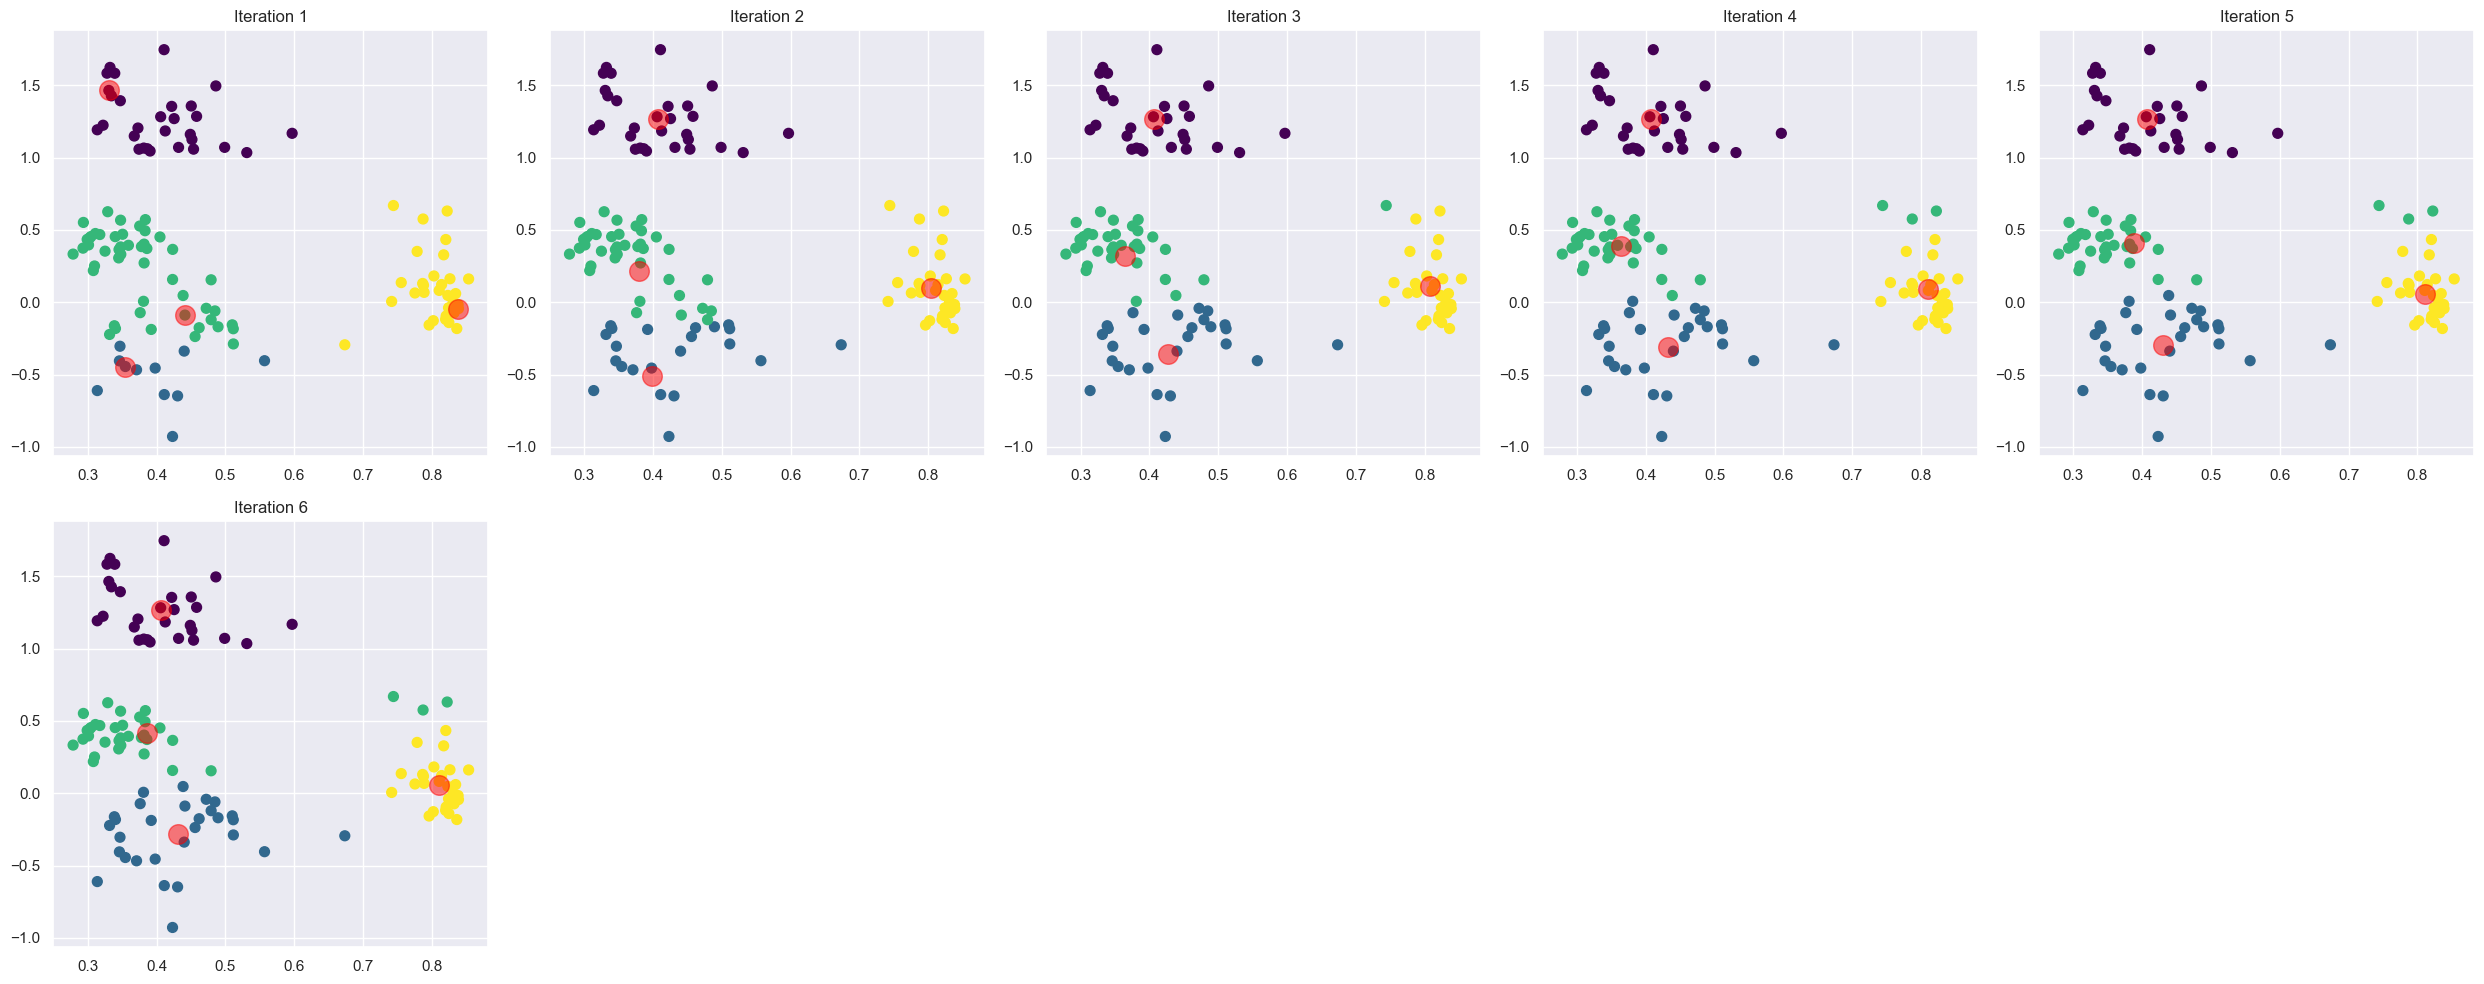

In [8]:
centers, labels = find_clusters(X, 4, rseed=0)

This is a common issue with many iterative algorithms, and the solution is to run the algorithm multiple times with different initializations (``n_init``). For that reason, Scikit-Learn does, by default, set by ``n_init`` parameter to 10.

#### Pre-selecting the Number of Clusters
A notable limitation of the *k*-means algorithm is its requirement for pre-specifying the number of clusters. Unlike some other algorithms, *k*-means doesn't have the capability to determine the optimal number of clusters directly from the data. 
For instance, if we instruct the algorithm to form six clusters, it will follow our direction and identify the best possible configuration of exactly six clusters.


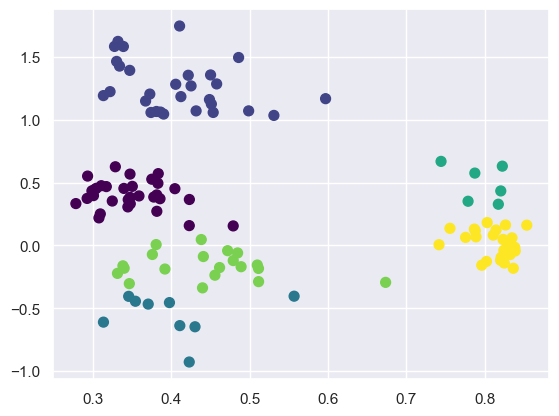

In [10]:
labels = KMeans(6, random_state=0, n_init=15).fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis');

A solution to this problem is known as the *Elbow Method*. It involves calculating the Within-Cluster Sum of Squares (WCSS) for a range of cluster numbers and then plotting these values. The "elbow" of the plot, where the rate of decrease sharply changes, can be a good indicator of the appropriate number of clusters.

Here's a step-by-step guide along with the code:

1. Calculate WCSS for Different Number of Clusters:

 - Iterate over a range of cluster numbers (e.g., 1 to 10).
 - For each number, fit the KMeans model and calculate the WCSS.
 
2. Plot the Results:

 - Plot the number of clusters against the WCSS.
 - Look for the "elbow" where the decrease in WCSS becomes less pronounced.


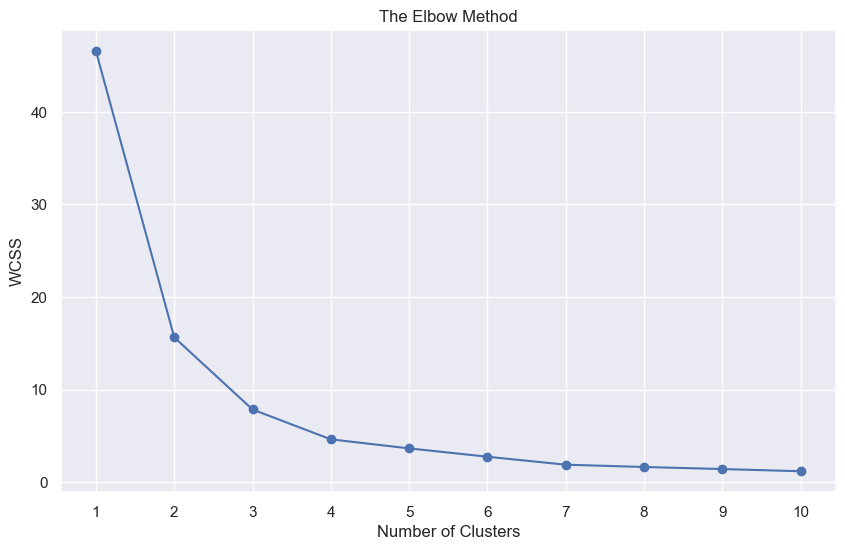

In [11]:
# Range of possible clusters
n_clusters = range(1, 11)

# Empty list to store WCSS
wcss = []

# Calculate WCSS for each number of clusters
for n in n_clusters:
    kmeans = KMeans(n_clusters=n, random_state=0, n_init=15).fit(X)
    wcss.append(kmeans.inertia_)

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(n_clusters, wcss, 'bo-')
plt.title('The Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.xticks(n_clusters)
plt.show()

Whether the result is meaningful is a question that is difficult to answer definitively; one approach that is rather intuitive, but that we won't discuss further here, is called [silhouette analysis](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html).

Alternatively, you might use a more complicated clustering algorithm which has a better quantitative measure of the fitness per number of clusters (e.g., Gaussian mixture models; see [In Depth: Gaussian Mixture Models](05.12-Gaussian-Mixtures.ipynb)) or which *can* choose a suitable number of clusters (e.g., DBSCAN, mean-shift, or affinity propagation, all available in the ``sklearn.cluster`` submodule)

#### Linear Nature of Cluster Boundaries in k-means
The intrinsic assumptions of *k*-means, primarily that each point is closer to the centroid of its own cluster than to any other, inherently shape the algorithm's effectiveness. This assumption leads to a significant limitation: k-means tends to create clusters with linear boundaries. As a result, it struggles with complex cluster geometries where linear separations do not suffice.

This limitation becomes particularly evident in scenarios where clusters have non-linear, intricate boundaries. Such situations reveal the inadequacy of *k*-means in capturing the true essence of the data's underlying structure. The following example demonstrates this limitation, showcasing how *k*-means classifies a given dataset with complex geometrical arrangements:


In [ ]:
X, y = make_moons(200, noise=.05, random_state=0)

In [ ]:
labels = KMeans(2, random_state=0, n_init=15).fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis');

#### One of many solutions : Spectral Clustering

A kernelized version of *k*-means is available in Scikit-Learn, implemented through the `SpectralClustering` estimator. This method leverages the concept of nearest neighbor graphs to transform the data into a higher-dimensional space. Once in this expanded space, the algorithm applies a traditional *k*-means approach to assign labels to the data points.

This process allows for more complex cluster geometries than standard *k*-means, as it essentially captures the data's manifold structure before applying the clustering algorithm.


In [ ]:
model = SpectralClustering(n_clusters=2, affinity='nearest_neighbors', assign_labels='kmeans')
labels = model.fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=50, cmap='viridis');

#### Scalability Challenges with k-means for Large Datasets
The *k*-means algorithm requires accessing every data point in each iteration, which can lead to performance issues as the size of the dataset increases. This naturally raises the question: is it possible to reduce the computational load by not using all the data in every step? Indeed, this concept is the basis for batch-based versions of *k*-means.

One such variant is implemented in Scikit-Learn as `sklearn.cluster.MiniBatchKMeans`. This approach involves using a random subset of data points in each iteration to update the cluster centers, significantly improving efficiency, particularly for large datasets. The usage of `MiniBatchKMeans` is similar to the standard `KMeans`, and we will explore an example of its application later in our discussion.

## Generate data

In [ ]:
from sklearn.datasets._samples_generator import make_blobs
X, y_true = make_blobs(n_samples=300, centers=4,
                       cluster_std=0.60, random_state=0)
plt.scatter(X[:, 0], X[:, 1], s=50);